In [54]:
# gubenatorial
# senate


# correlation table on the bimodality measures

In [55]:
# bimodality & gamma and serve the brutons!@#$%^&*()_+ 
#(new york election, maybe use a plotting method to inspect individual points more easliy [seaborn?])
# code "problem" elections, maybe sort across and see if there are any patterns
# get a rule that culls elections and only plot problem elections
# 

In [56]:
import sys
import os

# Add the parent directory to the sys.path
sys.path.append(os.path.join(os.getcwd(), '..'))

In [57]:
import seaborn as sns
import numpy as np

from scipy.stats import kurtosis, skew, gaussian_kde
from scipy.signal import argrelextrema

from rcv_learning.rcv_distribution import *
from rcv_learning.rcv_dimensionality import *

In [58]:
def compute_ecdf(data):
    """Compute the empirical cumulative distribution function (ECDF) of data."""
    sorted_data = np.sort(data)
    n = len(data)
    return sorted_data, np.arange(1, n+1) / n

def dip_statistic(data):
    """Compute Hartigan's dip statistic for data."""
    data = np.sort(data)
    n = len(data)
    
    # Compute the empirical CDF
    x, ecdf = compute_ecdf(data)
    
    # Compute the greatest difference on the left and right side for each data point
    U = np.arange(1, n+1) / n
    D = U - np.arange(0, n) / n
    
    # Calculate the difference between the empirical distribution function and the unimodal distribution function that minimizes that maximum difference.
    low_dip = (ecdf - D).clip(min=0)
    up_dip = (U - ecdf).clip(min=0)
    both_dips = np.column_stack((low_dip, up_dip))
    
    # The dip statistic is the maximum difference over all data points
    dip = np.max(both_dips)
    
    return dip

/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_exploration/../rcv_learning/rcv_dimensionality.py:188: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Normalized distances: {'Palin, Sarah': 0.0, 'Begich, Nick': 0.8299128528030508, 'Peltola, Mary S.': 2.0}


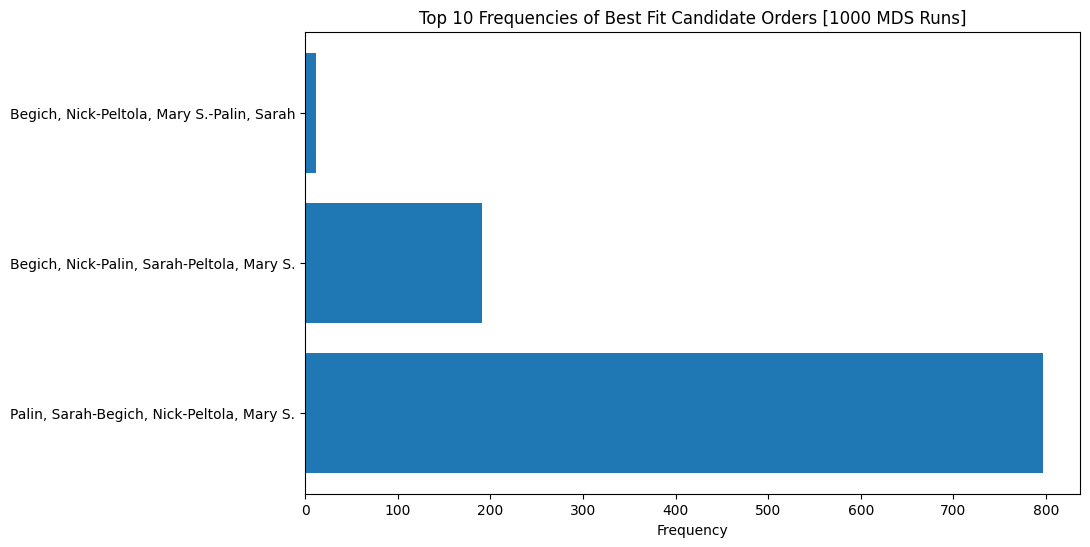

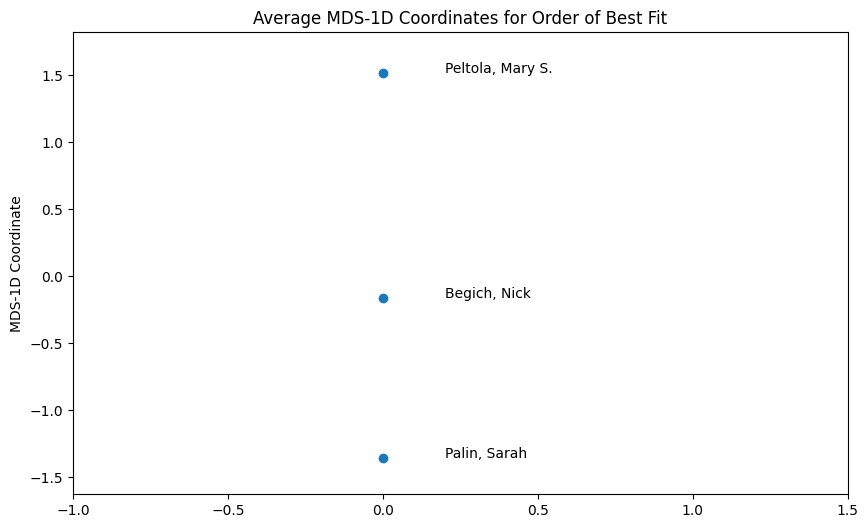

/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_exploration/../rcv_learning/rcv_dimensionality.py:188: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Consistency points: {0.2925217867992373: 26335, 0.0: 23660, 0.3962608933996187: 21154, 2.0: 21186, 1.2313044669980933: 7626, 1.1700871471969492: 11208, 1.3775653603977118: 19572, 0.5: 1443}


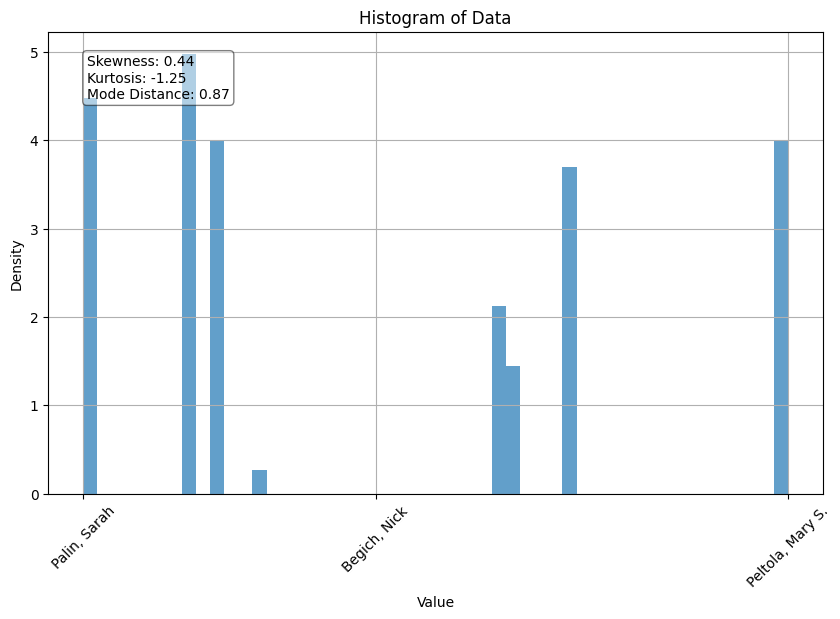

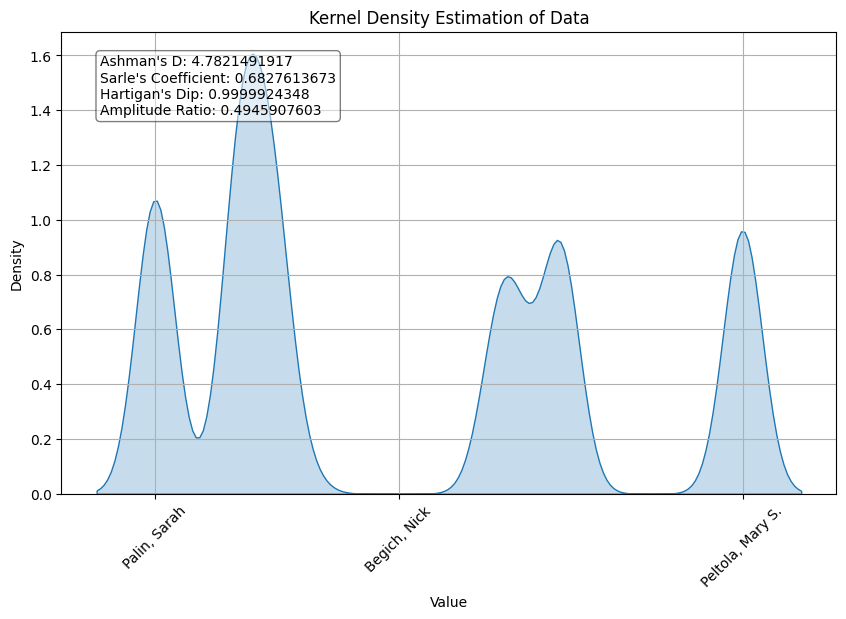

In [61]:
# Test the function with a custom CSV file
csv = "../rcv_elections_database/classic/Alaska_08162022_HouseofRepresentativesSpecial.csv"

# Determine save behavior
save = False
filename = csv.split("/")[-1]
filename_prefix = f"plots/{filename}"

# Perform the RCV analysis
test = perform_rcv_analysis(csv, n_runs=1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = test

# Print the normalized distances between candidates and plot the MDS analysis
normalized_distances = get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names)
print("Normalized distances:", normalized_distances)
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names, save=save, filename=filename_prefix)

# Get the consistency points for the bimodality analysis
points = get_consistency_points(csv)
print("Consistency points:", points)

# Create a list of data points
data_points = []
for key, value in points.items():
    data_points.extend([key] * value)

# Convert to numpy array
data_points = np.array(data_points)

# Calculate skewness and kurtosis
g = skew(data_points)
k = kurtosis(data_points)

# Calculate KDE without plotting
density = gaussian_kde(data_points)
x_vals = np.linspace(min(data_points), max(data_points), 1000)
y_vals = density(x_vals)

# Identify local maxima in the KDE
maxima_indices = argrelextrema(y_vals, np.greater)

# Get the x-values of the maxima
modes = x_vals[maxima_indices]

# Check if there are at least two modes
if len(modes) >= 2:
    mode1, mode2 = modes[:2]

    # Calculate the amplitudes of the two modes
    amp1 = density(mode1)[0]
    amp2 = density(mode2)[0]

    # Calculate the amplitude ratio with higher amplitude as denominator
    if amp1 > amp2:
        amplitude_ratio = amp2 / amp1
    else:
        amplitude_ratio = amp1 / amp2

    # Calculate x-axis distance between the two modes
    mode_distance = abs(mode2 - mode1)

else:
    mode1, mode2 = None, None
    amplitude_ratio = None
    mode_distance = None

try:
    # Split the data into two groups based on proximity to the modes
    data_group1 = [point for point in data_points if abs(point - mode1) < abs(point - mode2)]
    data_group2 = [point for point in data_points if abs(point - mode1) > abs(point - mode2)]

    # Display mean and variance for each group
    mu1, sigma1_sq = np.mean(data_group1), np.var(data_group1)
    mu2, sigma2_sq = np.mean(data_group2), np.var(data_group2)

    # Calculate Ashman's D statistic (D > 2)
    ashmans_D = abs(mu1 - mu2) / np.sqrt((sigma1_sq + sigma2_sq) / 2)
except:
    mode_distance = 404
    amplitude_ratio = 404
    ashmans_D = 404

# Calculate Sarle's bimodality coefficient b (b > 5/9)
n = len(data_points)
sarle = (g**2 + 1) / (k + 3 * (n-1)**2 / ((n-2) * (n-3)))

# Calculate Hartigan's dip statistic (calculate p value)
hartigan_dip = dip_statistic(data_points)

# Prepare data for histogram
data_list = [x for x, count in points.items() for _ in range(count)]
normalized_points = []
normalized_names = []
for name in normalized_distances:
    normalized_names.append(name)
    normalized_points.append(normalized_distances[name])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data_list, bins=50, density=True, alpha=0.7)
plt.title('Histogram of Data')
plt.xticks(normalized_points, normalized_names, rotation=45)
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)

# Display measures in a text box
text_str = f"Skewness: {g:.2f}\nKurtosis: {k:.2f}\nMode Distance: {mode_distance:.2f}"
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

if save:
    plt.savefig(f"{filename_prefix}_hist.png", bbox_inches='tight')
    plt.close()
else:
    plt.show()

# Plot kernal density estimation
plt.figure(figsize=(10, 6))
sns.kdeplot(data_list, fill=True)
plt.title('Kernel Density Estimation of Data')
plt.xticks(normalized_points, normalized_names, rotation=45)
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)

# Display bimodality measures in a text box
text_str = f"Ashman's D: {ashmans_D:.10f}\nSarle's Coefficient: {sarle:.10f}\nHartigan's Dip: {hartigan_dip:.10f}\nAmplitude Ratio: {amplitude_ratio:.10f}"
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

if save:
    plt.savefig(f"{filename_prefix}_kde.png", bbox_inches='tight')
    plt.close()
else:
    plt.show()